Comparing PHOEBE 2 vs PHOEBE Legacy
============================

**NOTE**: PHOEBE 1.0 legacy is an alternate backend and is not installed with PHOEBE 2.  In order to run this backend, you'll need to have [PHOEBE 1.0](https://phoebe-project.org/1.0) installed and manually build the python bindings in the `phoebe-py` directory.

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

As always, let's do imports and initialize a logger and a new bundle.

In [2]:
import phoebe
from phoebe import u
import numpy as np
import matplotlib.pyplot as plt

phoebe.devel_on()  # needed to use WD-style meshing, which isn't fully supported yet

logger = phoebe.logger()

b = phoebe.default_binary()
b['q'] = 0.7
b['requiv@secondary'] = 0.7

Thu, 17 Sep 2020 18:04 BUNDLE       ERROR   Constraint 'ebv@extinction@constraint' raised the following error while setting the value of 'ebv@system'.  Original error: 0 results found for twig: 'None', {'qualifier': 'run_checks_compute', 'context': 'setting', 'check_visible': False, 'check_default': False, 'check_advanced': False, 'check_single': False}


Adding Datasets and Compute Options
--------------------

In [3]:
b.add_dataset('lc', times=np.linspace(0,1,101), dataset='lc01')
b.add_dataset('rv', times=np.linspace(0,1,101), dataset='rvdyn')
b.add_dataset('rv', times=np.linspace(0,1,101), dataset='rvnum')

<ParameterSet: 45 parameters | contexts: figure, constraint, compute, dataset>

Let's add compute options for phoebe using both the new (marching) method for creating meshes as well as the WD method which imitates the format of the mesh used within legacy.

In [4]:
b.add_compute(compute='phoebe2marching', irrad_method='none', mesh_method='marching')

<ParameterSet: 56 parameters | datasets: _default, rvdyn, lc01, rvnum>

In [5]:
b.add_compute(compute='phoebe2wd', irrad_method='none', mesh_method='wd', eclipse_method='graham')

<ParameterSet: 56 parameters | datasets: _default, rvdyn, lc01, rvnum>

Now we add compute options for the 'legacy' backend.

In [6]:
b.add_compute('legacy', compute='phoebe1', irrad_method='none')

<ParameterSet: 34 parameters | datasets: _default, rvdyn, lc01, rvnum>

And set the two RV datasets to use the correct methods (for both compute options)

In [7]:
b.set_value_all('rv_method', dataset='rvdyn', value='dynamical')

Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_c

Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at r

In [8]:
b.set_value_all('rv_method', dataset='rvnum', value='flux-weighted')

Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_c

Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at r

Let's use the external atmospheres available for both phoebe1 and phoebe2

In [9]:
b.set_value_all('atm', 'extern_planckint')

Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:04 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_c

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe01 or ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe01 or ld_mode@secondary@rvdyn.  If not addressed, this warning will continue to be raised an

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe2marching or ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe01 or ld_mode@secondary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe2marching or ld_mode@secondary@rvdyn.  If not addressed, this warning 

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2wd or ld_mode@primary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe01 or ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2marching or ld_mode@primary@rvnum.  If not addressed, this warning will continue to b

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe2marching or ld_mode@secondary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe2wd or ld_mode@secondary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe01 or ld_mode@secondary@rvnum.  If not addressed, this warning will

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2marching or ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2wd or ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe01 or ld_mode@primary@rvdyn.  If not addressed, this warning will continue to be r

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2marching or ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2wd or ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe01 or ld_mode@secondary@lc01.  If not addressed, this warning will continue t

Let's make sure both 'phoebe1' and 'phoebe2wd' use the same value for gridsize

In [10]:
b.set_value_all('gridsize', 30)

Let's also disable other special effect such as heating, gravity, and light-time effects.

In [11]:
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_func', 'logarithmic')
b.set_value_all('ld_coeffs', [0.,0.])

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe01 or ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2marching or ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2wd or ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@lc01.  If not addressed, this warning will continue to be ra

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe01 or ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe2marching or ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@secondary@phoebe2wd or ld_mode@secondary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@lc01.  If not addressed, this warning will con

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@primary@rvdyn.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe01 or ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2marching or ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2wd or ld_mode@primary@rvnum.  If not addressed, this warning will continue to b

Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by 'legacy' backend used by compute='phoebe1'.  Change ld_mode@secondary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe01 or ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2marching or ld_mode@primary@rvnum.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Thu, 17 Sep 2020 18:05 BUNDLE       WARNING ld_mode='interp' not supported by atm='extern_planckint'.  Either change atm@primary@phoebe2wd or ld_mode@primary@rvnum.  If not addressed, this warning will continue to

In [12]:
b.set_value_all('rv_grav', False)

In [13]:
b.set_value_all('ltte', False)

Finally, let's compute all of our models

In [14]:
b.run_compute(compute='phoebe2marching', model='phoebe2marchingmodel')

100%|██████████| 101/101 [00:01<00:00, 82.55it/s]


<ParameterSet: 11 parameters | kinds: rv, lc>

In [15]:
b.run_compute(compute='phoebe2wd', model='phoebe2wdmodel')

100%|██████████| 101/101 [00:02<00:00, 48.46it/s]


<ParameterSet: 11 parameters | kinds: rv, lc>

In [16]:
b.run_compute(compute='phoebe1', model='phoebe1model')

Thu, 17 Sep 2020 18:05 IO           WARNING requiv_max@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING logg@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING freq@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING pitch@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING yaw@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING long_an@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING irrad_frac_lost_bol@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING ld_mode_bol@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING ld_func_bol@primary@star@component has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING ld_coeffs_source_bol@primary@star@co

Thu, 17 Sep 2020 18:05 IO           WARNING rv_grav@secondary@rvdyn@phoebe2wd@phoebe@compute has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING rv_method@secondary@rvdyn@phoebe1@legacy@compute has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING compute_times@rvnum@rv@dataset has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING mask_enabled@rvnum@rv@dataset has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING solver_times@rvnum@rv@dataset has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING intens_weighting@rvnum@rv@dataset has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING rv_method@primary@rvnum@phoebe01@phoebe@compute has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING rv_grav@primary@rvnum@phoebe01@phoebe@compute has no phoebe 1 corollary
Thu, 17 Sep 2020 18:05 IO           WARNING sigmas_lnf@primary@rvnum@rv@dataset has no phoebe 1 corollary
Thu, 17 Sep 2020 

<ParameterSet: 11 parameters | kinds: rv, lc>

Plotting
-------------------------

### Light Curve

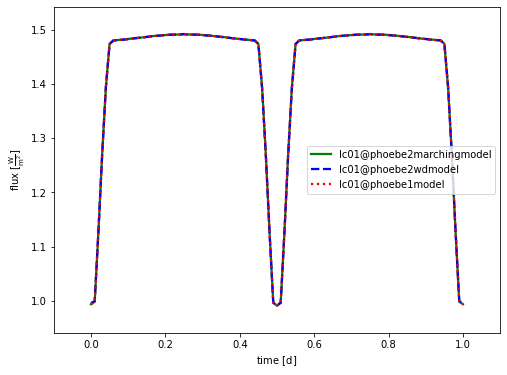

In [17]:
colors = {'phoebe2marchingmodel': 'g', 'phoebe2wdmodel': 'b', 'phoebe1model': 'r'}
afig, mplfig = b['lc01'].plot(c=colors, legend=True, show=True)

Now let's plot the residuals between these two models

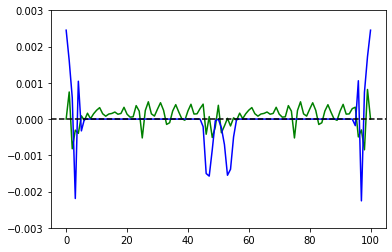

In [18]:
artist, = plt.plot(b.get_value('fluxes@lc01@phoebe2marchingmodel') - b.get_value('fluxes@lc01@phoebe1model'), 'g-')
artist, = plt.plot(b.get_value('fluxes@lc01@phoebe2wdmodel') - b.get_value('fluxes@lc01@phoebe1model'), 'b-')
artist = plt.axhline(0.0, linestyle='dashed', color='k')
ylim = plt.ylim(-0.003, 0.003)

### Dynamical RVs

Since the dynamical RVs don't depend on the mesh, there should be no difference between the 'phoebe2marching' and 'phoebe2wd' synthetic models.  Here we'll just choose one to plot.

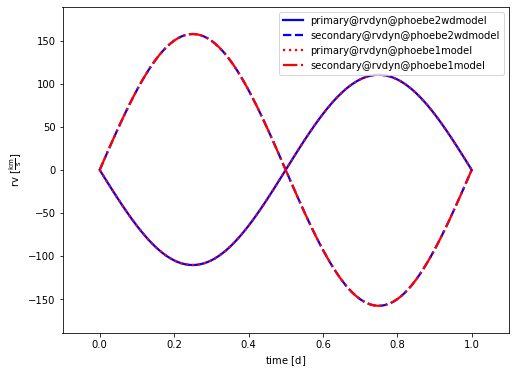

In [19]:
afig, mplfig = b.filter(dataset='rvdyn', model=['phoebe2wdmodel', 'phoebe1model']).plot(c=colors, legend=True, show=True)

And also plot the residuals of both the primary and secondary RVs (notice the scale on the y-axis)

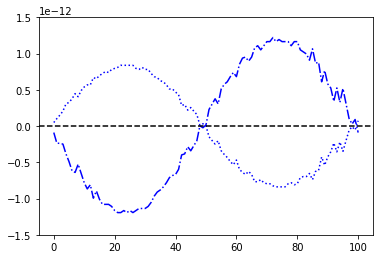

In [20]:
artist, = plt.plot(b.get_value('rvs@rvdyn@primary@phoebe2wdmodel') - b.get_value('rvs@rvdyn@primary@phoebe1model'), color='b', ls=':')
artist, = plt.plot(b.get_value('rvs@rvdyn@secondary@phoebe2wdmodel') - b.get_value('rvs@rvdyn@secondary@phoebe1model'), color='b', ls='-.')
artist = plt.axhline(0.0, linestyle='dashed', color='k')
ylim = plt.ylim(-1.5e-12, 1.5e-12)

### Numerical (flux-weighted) RVs

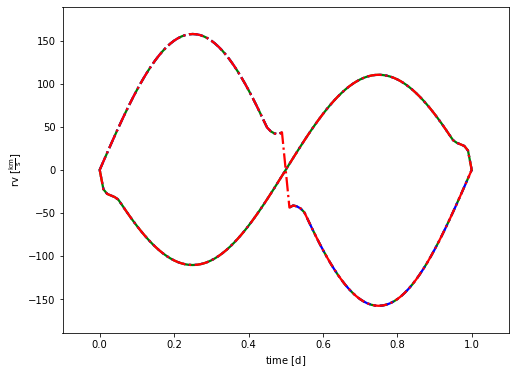

In [21]:
afig, mplfig = b.filter(dataset='rvnum').plot(c=colors, show=True)

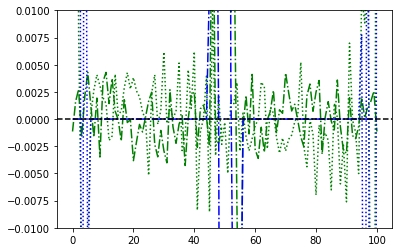

In [22]:
artist, = plt.plot(b.get_value('rvs@rvnum@primary@phoebe2marchingmodel', ) - b.get_value('rvs@rvnum@primary@phoebe1model'), color='g', ls=':')
artist, = plt.plot(b.get_value('rvs@rvnum@secondary@phoebe2marchingmodel') - b.get_value('rvs@rvnum@secondary@phoebe1model'), color='g', ls='-.')

artist, = plt.plot(b.get_value('rvs@rvnum@primary@phoebe2wdmodel', ) - b.get_value('rvs@rvnum@primary@phoebe1model'), color='b', ls=':')
artist, = plt.plot(b.get_value('rvs@rvnum@secondary@phoebe2wdmodel') - b.get_value('rvs@rvnum@secondary@phoebe1model'), color='b', ls='-.')

artist = plt.axhline(0.0, linestyle='dashed', color='k')
ylim = plt.ylim(-1e-2, 1e-2)